## Training RNN

What makes this complicated is that
- use pytorch's default initialization (any other standard techniques won't work)
- use Adam (SGD is very shitty, doesn't even converge often)
- use tanh if using vanilla RNN, relu has issues.
- use bigger capacity network (increased number of hidden cells from 2 to 5; even though 2 is enough to learn the task).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from time import time
torch.manual_seed(1)

In [3]:
class RNNNet2(nn.Module):
  def __init__(self, in_size=2, hidden_size=5, out_size=2, style='lstm'):
    """
    in_size -> state space goes in here, so size of the state features
    hidden_size -> hidden vector size in the LSTM
    out_size -> number of actions
    """
    super(RNNNet2, self).__init__()
    self.hidden_size = hidden_size
    self.style = style
    if(style=='lstm'):
      self.rnn = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
    elif(style=='rnn'):
      self.rnn = nn.RNN(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
    self.fc_head = nn.Linear(hidden_size, out_size)
    # for p in list(self.parameters()): # initialize all parameters to 0
    #   p.data.fill_(np.random.rand())
   
    self.hidden_state = torch.zeros(1, 1, hidden_size) # layer x bs x hidden_dims
    
  def reset_hidden_states(self):
    return torch.zeros(1, 1, self.hidden_size) # layer x bs x hidden_dims
  
  def forward(self, x): 
    """
    x -> timesteps x num_features
    """
    if(self.style=='lstm'):
      hidden_state =  (torch.zeros(1, 1, self.hidden_size),torch.zeros(1, 1, self.hidden_size))
    else:
      hidden_state =  torch.zeros(1, 1, self.hidden_size)
    x = x.view(1, -1, x.size(-1)) # reshape to include batch
    # phi = phi.view(1, phi.size(0), phi.size(1)) # seq_len, batch, feature
    y, _ = self.rnn(x, hidden_state)  # y-> seq_len, batch, input_size      
    y = y.squeeze(0)
    q = self.fc_head(y)
    return q

time taken (seconds):  1.3561792373657227
tensor([[ 1.0000,  1.0000],
        [ 1.0000, -1.0000]], grad_fn=<AddmmBackward>)
tensor([[ 1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<AddmmBackward>)


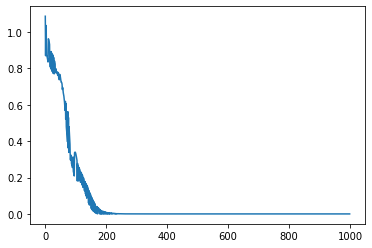

In [11]:
# datapoint 1
# x_1 = [1, 0]; y_1 = [1, 1]
# x_2 = [1, 1]; y_2 = [1, -1]

# datapoint 2
# x_1 = [0, 1]; y_1 = [1, 1]
# x_2 = [1, 1]; y_2 = [-1, 1]

x_data = torch.Tensor([[[1,0],[1,1]],
     [[0,1],[1,1]]]) # i x 
t_data = torch.Tensor([[[1,1],[1,-1]],
     [[1,1],[-1,1]]])
rnn = RNNNet2(style='lstm')
optimizer = torch.optim.AdamW(rnn.parameters(), lr=0.01, weight_decay=1e-4)

loss_vec = []
start = time()
for i in range(1000):
  # Choose a point randomly
  choice = np.random.randint(0,2)
  x = x_data[choice,:,:].unsqueeze(0)
  t = t_data[choice,:,:].unsqueeze(0)

  out = rnn(x_data[choice,:,:])
  target = t_data[choice,:,:]

  # use out-target to update paramters
  loss = (out-target).pow(2).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss_vec.append(loss.data.numpy())

print('time taken (seconds): ', time()-start)
plt.plot(loss_vec)
print(rnn(x_data[0,:,:]))
print(rnn(x_data[1,:,:]))

In [ ]:
time()

1590778762.1536832

In [ ]:
# Lab 12 RNN
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(777)  # reproducibility
#            0    1    2    3    4
idx2char = ['h', 'i', 'e', 'l', 'o']

# Teach hihell -> ihello
x_data = [0, 1, 0, 2, 3, 3]   # hihell
one_hot_lookup = [[1, 0, 0, 0, 0],  # 0
                  [0, 1, 0, 0, 0],  # 1
                  [0, 0, 1, 0, 0],  # 2
                  [0, 0, 0, 1, 0],  # 3
                  [0, 0, 0, 0, 1]]  # 4

y_data = [1, 0, 2, 3, 3, 4]    # ihello
x_one_hot = [one_hot_lookup[x] for x in x_data]

# As we have one batch of samples, we will change them to variables only once
inputs = Variable(torch.Tensor(x_one_hot))
labels = Variable(torch.LongTensor(y_data))

num_classes = 5
input_size = 5  # one-hot size
hidden_size = 5  # output from the RNN. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 1  # One by one
num_layers = 1  # one-layer rnn


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size, batch_first=True)

    def forward(self, hidden, x):
        # Reshape input (batch first)
        x = x.view(batch_size, sequence_length, input_size)

        # Propagate input through RNN
        # Input: (batch, seq_len, input_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(x, hidden)
        return hidden, out.view(-1, num_classes)

    def init_hidden(self):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))


# Instantiate RNN model
model = Model()
print(model)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    loss = 0
    hidden = model.init_hidden()

    sys.stdout.write("predicted string: ")
    for input, label in zip(inputs, labels):
        # print(input.size(), label.size())
        hidden, output = model(hidden, input)
        if(epoch%10==0):
          print(output)
        val, idx = output.max(1)
        sys.stdout.write(idx2char[idx.data[0]])
        loss += criterion(output, label.unsqueeze(0))

    print(", epoch: %d, loss: %1.3f" % (epoch + 1, loss.data.numpy()))

    loss.backward()
    optimizer.step()

print("Learning finished!")

Model(
  (rnn): RNN(5, 5, batch_first=True)
)
predicted string: tensor([[ 0.3700, -0.3483, -0.1920,  0.8472,  0.5825]], grad_fn=<ViewBackward>)
ltensor([[ 0.3980, -0.2673,  0.0557,  0.7950, -0.1108]], grad_fn=<ViewBackward>)
ltensor([[ 0.2075, -0.0678, -0.0524,  0.8995,  0.3951]], grad_fn=<ViewBackward>)
ltensor([[ 0.3693, -0.3595, -0.3093,  0.6169,  0.0625]], grad_fn=<ViewBackward>)
ltensor([[ 0.4521, -0.2301,  0.1093,  0.8236, -0.0534]], grad_fn=<ViewBackward>)
ltensor([[ 0.4576, -0.1116,  0.2538,  0.8705, -0.2188]], grad_fn=<ViewBackward>)
l, epoch: 1, loss: 10.155
predicted string: llllll, epoch: 2, loss: 9.137
predicted string: llllll, epoch: 3, loss: 8.355
predicted string: llllll, epoch: 4, loss: 7.577
predicted string: llllll, epoch: 5, loss: 6.876
predicted string: lhelll, epoch: 6, loss: 6.327
predicted string: ihelll, epoch: 7, loss: 6.014
predicted string: ihelll, epoch: 8, loss: 5.787
predicted string: ihelll, epoch: 9, loss: 5.477
predicted string: ihelll, epoch: 10, loss